In [ ]:
# Adrian Marinovich
# Springboard - Data Science Career Track
# Relax Take-home Exercise
# January 28, 2019
#

# Report

The overall proportion of users who adopted was about 18.8%, suggesting there are opportunities for improvement. Our analysis used a logistic regression model to attain an accuracy of approximately 82% in predicting user adoption in the test set. Our analysis reveals two chief groups of user features that predict user adoption: those that are relatively common among users and show small but significant effects on user adoption; and those that are quite rare but show large and significant effects on adoption. 

Among the common features in the first group were the Google authentication (SIGNUP_GOOGLE_AUTH) and website (SIGNUP) methods of account creation, seen in 16% and 21% of users respectively, and were each found to have approximately 1.5 times _lower_ odds of adoption compared to those in the other account groups combined. Those joining another user's personal workspace (PERSONAL_PROJECTS, 9% of users) had a 1.06 times _lower_ odds of adoption. In contrast, those with a guest invitation (GUEST_INVITE), making up 18% of users, were found to have 1.03 times _higher_ odds of adoption compared to all other groups. While these effect sizes are small, they are statistically significant, and the combined high prevalence of these features among users indicates the potential impact on overall user adoption. Targetted outreach efforts to users based on account creation method is warranted.

The more rare features in the second group primarily concerned certain organization identifications (org_id) of the users. While there were over 400 such identifications, and as such could not all be inserted into a parsimonious model, a small subset consisting of 4 organization identifiers was chosen for the model, each with a mean adoption rate of greater than 50% among associated users. Each of these organization identifiers (387, 235, 289 and 273) showed greater than 2.5 times _higher_ odds of adoption compared to the other combined identifiers, with identifier 387 showing approximately 5 times higher adoption odds. While the users belonging to these 4 organizations made up only 0.46% of all users all together, the high magnitude of the effect on adoption suggests further efforts should be undertaken to determine commonalities or other features among these organizations that could be targeted for understaning and improving user adoption. 

#### Assignment overview:

The data is available as two attached CSV files:
takehome_user_engagement.csv
takehome_users.csv
The data has the following two tables:

1] A user table ("takehome_users") with data on 12,000 users who signed up for the
product in the last two years. This table includes:

name: the user's name

object_id: the user's id

email: email address

creation_source: how their account was created. This takes on one
of 5 values:
 PERSONAL_PROJECTS: invited to join another user's
personal workspace
 GUEST_INVITE: invited to an organization as a guest
(limited permissions)
 ORG_INVITE: invited to an organization (as a full member)
 SIGNUP: signed up via the website
 SIGNUP_GOOGLE_AUTH: signed up using Google
Authentication (using a Google email account for their login
id)

creation_time: when they created their account

last_session_creation_time: unix timestamp of last login

opted_in_to_mailing_list: whether they have opted into receiving
marketing emails

enabled_for_marketing_drip: whether they are on the regular
marketing email drip

org_id: the organization (group of users) they belong to

invited_by_user_id: which user invited them to join (if applicable).

2] A usage summary table ("takehome_user_engagement") that has a row for each day
that a user logged into the product.
Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one seven-day period, identify which factors predict future user
adoption.

Please send us a brief writeup of your findings (the more concise, the better - no more
than one page), along with any summary tables, graphs, code, or queries that can help
us understand your approach. Please note any factors you considered or investigation
you did, even if they did not pan out. Feel free to identify any further research or data
you think would be valuable.

In [2]:
import numpy as np
import pandas as pd
import json
import sklearn.model_selection

from pandas.io.json import json_normalize
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.svm import LinearSVC 

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid")
sns.set_context("paper")
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

In [3]:
pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 100)

In [4]:
# Read the csv in to a pandas dataframe
usage_df = pd.read_csv('sb_data/takehome_user_engagement.csv')

In [5]:
# View data types
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [6]:
# View top of dataframe
usage_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
# Set time_stamp as datetime64 type with times removed,
#  drop 'visited' variable since it's all 1s,

usage_df.time_stamp = pd.DatetimeIndex(usage_df.time_stamp, dtype='datetime64[D]')
usage_df = usage_df.drop(['visited'], axis=1)
#usage_df = usage_df.drop_duplicates()

In [8]:
# Set time_stamp as index and set its column to int64
usage_df['ind'] = usage_df.time_stamp
usage_df.time_stamp = usage_df.time_stamp.astype(np.int64)
usage_df = usage_df.set_index('ind')

In [9]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 2 columns):
time_stamp    207917 non-null int64
user_id       207917 non-null int64
dtypes: int64(2)
memory usage: 4.8 MB


In [10]:
usage_df.head(20)

,time_stamp,user_id
ind,,
2014-04-22 03:53:30,1398138810000000000,1
2013-11-15 03:45:04,1384487104000000000,2
2013-11-29 03:45:04,1385696704000000000,2
2013-12-09 03:45:04,1386560704000000000,2
2013-12-25 03:45:04,1387943104000000000,2
2013-12-31 03:45:04,1388461504000000000,2
2014-01-08 03:45:04,1389152704000000000,2
2014-02-03 03:45:04,1391399104000000000,2
2014-02-08 03:45:04,1391831104000000000,2


In [11]:
# Create variable 'adopted' by counting interval (in days) of
#  occurence of 3 login days, grouped by user, then set
#  'adopted' boolean to True when interval <=7

i = pd.to_timedelta((usage_df.groupby('user_id')['time_stamp'].rolling(3).max() - \
                     usage_df.groupby('user_id')['time_stamp'].rolling(3).min())).dt.days \
        <= 7

In [12]:
# Extract user_id from multi-index
#  pull out 'adopted' variable as Series, 
#  combine with user_id as index into new dataframe,
#  set 'adopted' boolean to integer

i_indx = i.index.get_level_values('user_id').tolist()
i_s = pd.Series(i)
i_df = pd.DataFrame(list(zip(i_indx, i_s)), columns=['user_id','adopted'])
i_df.adopted = i_df.adopted.astype(np.int8)

In [13]:
# Create series with unique user_id with boolean
#  set to any occurrence of adoption for a user
adopt_s = i_df.groupby('user_id')['adopted'].sum() > 0

In [14]:
# Convert to dataframe in order to merge
adopt_df = pd.Series.to_frame(adopt_s)

In [15]:
# Read the users csv in to a pandas dataframe
#  (note that it had to be converted to UTF8
#   beforehand)
users_df = pd.read_csv('sb_data/takehome_users_utf8.csv')

In [16]:
# Merge in the 'adopted' variable and set to integer
users_df = pd.merge(users_df, adopt_df, left_on='object_id', right_index=True)

users_df.adopted = users_df.adopted.astype(np.int8)

In [17]:
users_df.shape

(8823, 11)

In [18]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     8823 non-null int64
creation_time                 8823 non-null object
name                          8823 non-null object
email                         8823 non-null object
creation_source               8823 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      8823 non-null int64
enabled_for_marketing_drip    8823 non-null int64
org_id                        8823 non-null int64
invited_by_user_id            4776 non-null float64
adopted                       8823 non-null int8
dtypes: float64(2), int64(4), int8(1), object(4)
memory usage: 766.8+ KB


In [20]:
users_df.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [21]:
result = users_df.groupby('org_id')['adopted'].mean()
result = result.sort_values(ascending=False)

print('Mean adoption by user\'s organization ID:\n',
      '(top 10 organizations)\n',
      result[0:9])

Mean adoption by user's organization ID:
 (top 10 organizations)
 org_id
387    0.636364
235    0.600000
273    0.555556
289    0.545455
400    0.500000
392    0.500000
386    0.500000
117    0.500000
399    0.500000
Name: adopted, dtype: float64


In [22]:
print('Proportion of users by creation source:\n',
      users_df['creation_source'].value_counts() / users_df.shape[0])

Proportion of users by creation source:
 ORG_INVITE            0.361328
SIGNUP                0.215120
GUEST_INVITE          0.179984
SIGNUP_GOOGLE_AUTH    0.156976
PERSONAL_PROJECTS     0.086592
Name: creation_source, dtype: float64


In [23]:
# Create new dummy variable to code categorical variables 
users_df['org_invite'] = users_df['creation_source']=='ORG_INVITE'
users_df['signup'] = users_df['creation_source']=='SIGNUP'
users_df['guest_invite'] = users_df['creation_source']=='GUEST_INVITE'
users_df['google_auth'] = users_df['creation_source']=='SIGNUP_GOOGLE_AUTH'
users_df['personal_proj'] = users_df['creation_source']=='PERSONAL_PROJECTS'

users_df['org_invite'] = users_df['org_invite'].astype(np.int8)
users_df['signup'] = users_df['signup'].astype(np.int8)
users_df['guest_invite'] = users_df['guest_invite'].astype(np.int8)
users_df['google_auth'] = users_df['google_auth'].astype(np.int8)
users_df['personal_proj'] = users_df['personal_proj'].astype(np.int8)

# Create dummy variables to code certain org_id shown to have 
#   > 50% adoption as shown above
users_df['org_387'] = users_df['org_id']==387
users_df['org_235'] = users_df['org_id']==235
users_df['org_273'] = users_df['org_id']==273
users_df['org_289'] = users_df['org_id']==289

users_df['org_387'] = users_df['org_387'].astype(np.int8)
users_df['org_235'] = users_df['org_235'].astype(np.int8)
users_df['org_273'] = users_df['org_273'].astype(np.int8)
users_df['org_289'] = users_df['org_289'].astype(np.int8)

In [24]:
print('The proportion of users adopted (i.e., 3 days w/login in a 7 day interval):', 
       users_df['adopted'][users_df['adopted']==True].count() / users_df.shape[0])

The proportion of users adopted (i.e., 3 days w/login in a 7 day interval): 0.18769126147568854


In [25]:
users_df.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,org_invite,signup,guest_invite,google_auth,personal_proj,org_387,org_235,org_273,org_289
count,8823.000000,8.823000e+03,8823.000000,8823.000000,8823.000000,4776.000000,8823.000000,8823.000000,8823.000000,8823.000000,8823.000000,8823.000000,8823.000000,8823.000000,8823.000000,8823.000000
mean,6019.821716,1.379279e+09,0.252295,0.151989,142.572254,5980.495394,0.187691,0.361328,0.215120,0.179984,0.156976,0.086592,0.001247,0.001133,0.001020,0.001247
std,3464.251001,1.953116e+07,0.434354,0.359031,124.176422,3394.211361,0.390488,0.480413,0.410929,0.384196,0.363799,0.281252,0.035289,0.033649,0.031924,0.035289
min,1.000000,1.338452e+09,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3017.500000,1.363195e+09,0.000000,0.000000,30.000000,3071.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6034.000000,1.382888e+09,0.000000,0.000000,109.000000,5947.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9029.500000,1.398443e+09,1.000000,0.000000,239.000000,8857.250000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12000.000000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
# Create a predictive analysis dataset using
#  select feature variables and 'adopted', 
#  and drop rows with missing values

select_vars = ['opted_in_to_mailing_list', 
               'enabled_for_marketing_drip',
               'org_invite',
               'signup',
               'guest_invite',
               'google_auth',
               'personal_proj',
               'org_387',
               'org_235',
               'org_273',
               'org_289']
selects = select_vars + ['adopted']

u_df_nona = users_df[selects]
u_df_nona = u_df_nona.dropna()

In [28]:
u_df_nona.shape

(8823, 12)

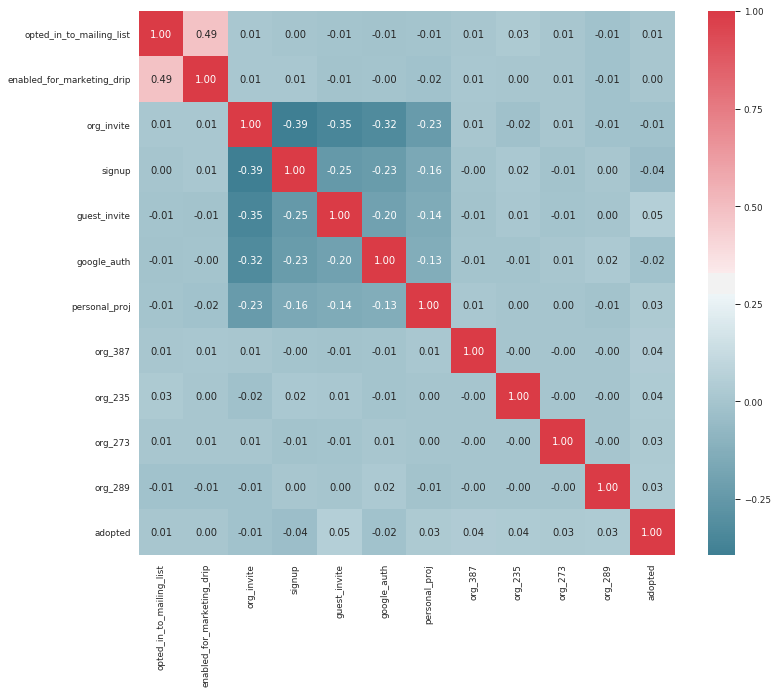

In [29]:
# Create heatmapped correlation matrix of select variables
corr = u_df_nona.corr()
fig, ax = plt.subplots(figsize=(12, 10))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
plt.show()

In [30]:
# Split the data into training and test sets
Xlr, Xtestlr, ylr, ytestlr = train_test_split(u_df_nona[select_vars].values, 
                                              u_df_nona.adopted.values,
                                              test_size=0.2,
                                              random_state=5)

In [31]:
# Set up logistic regression

lgr_clf = LogisticRegression()

# Fit on the training data
lgr_clf.fit(Xlr, ylr)

# View accuracy on the test data
print(accuracy_score(lgr_clf.predict(Xtestlr), ytestlr))

0.8209631728045326


#### No significant improvement is found with grid search (data not shown), so we will use the original logistic regression model.

In [32]:
# Obtain p values from chi2

scores, pvalues = chi2(Xlr, ylr)
pvalues

array([8.60045680e-01, 7.41116333e-01, 4.29773558e-01, 1.98242531e-02,
       4.87323607e-06, 1.10213614e-02, 3.94244825e-02, 3.89882633e-05,
       5.15168313e-03, 2.53030767e-02, 2.53030767e-02])

In [33]:
# Create new dataframe showing feature names and 
#  their logistic regression coefficients and p values,
#  after first obtaining odds ratios

ors = np.exp(lgr_clf.coef_)
ors = ors[0]
ors

array([0.99397706, 1.03472291, 0.7420657 , 0.65728853, 1.03931301,
       0.62845835, 0.94223956, 4.96161102, 3.18958665, 2.6235354 ,
       2.73585527])

In [34]:
lgr_c_p = list(zip(lgr_clf.coef_[0],ors, pvalues))
lgr_features = pd.DataFrame(lgr_c_p,
                                   index = select_vars,
                                   columns=['LGR_Coefficient','Odds Ratio','p_value'])

In [35]:
lgr_features.iloc[lgr_features['LGR_Coefficient'].abs().argsort()[::-1]]

,LGR_Coefficient,Odds Ratio,p_value
org_387,1.601730,4.961611,0.000039
org_235,1.159891,3.189587,0.005152
org_289,1.006444,2.735855,0.025303
org_273,0.964523,2.623535,0.025303
google_auth,-0.464486,0.628458,0.011021
signup,-0.419632,0.657289,0.019824
org_invite,-0.298317,0.742066,0.429774
personal_proj,-0.059496,0.942240,0.039424
guest_invite,0.038560,1.039313,0.000005
enabled_for_marketing_drip,0.034134,1.034723,0.741116


In [36]:
lgr_features['1_-_pvalue'] = 1 - lgr_features.p_value
var_na = ['LGR_Coefficient',
          '1_-_pvalue']

for x in var_na:
    lgr_features[x] = lgr_features[x].abs()
    lgr_features[x] = (lgr_features[x] - lgr_features[x].min()) / \
                      (lgr_features[x].max() - lgr_features[x].min())

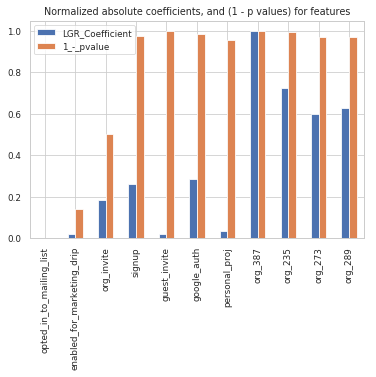

In [37]:
lgr_plot = lgr_features[['LGR_Coefficient', '1_-_pvalue']]
lgr_plot.plot.bar(title='Normalized absolute coefficients, and (1 - p values) for features')